<a href="https://colab.research.google.com/github/arslansevval/BreastCancerClassificationwithKNN/blob/master/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
#assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [3]:
# Common imports
import numpy as np
import pandas as pd

# To plot pretty figures
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Load the data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv")
data.drop(['Unnamed: 32', 'id'], inplace = True, axis = 1)
data = data.rename(columns = {"diagnosis" :"target" })
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]
print(data.head(10))

   target  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0       1        17.99  ...          0.4601                  0.11890
1       1        20.57  ...          0.2750                  0.08902
2       1        19.69  ...          0.3613                  0.08758
3       1        11.42  ...          0.6638                  0.17300
4       1        20.29  ...          0.2364                  0.07678
5       1        12.45  ...          0.3985                  0.12440
6       1        18.25  ...          0.3063                  0.08368
7       1        13.71  ...          0.3196                  0.11510
8       1        13.00  ...          0.4378                  0.10720
9       1        12.46  ...          0.4366                  0.20750

[10 rows x 31 columns]


In [6]:
data.isnull().values.any()
#missing value:none

False

0    357
1    212
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


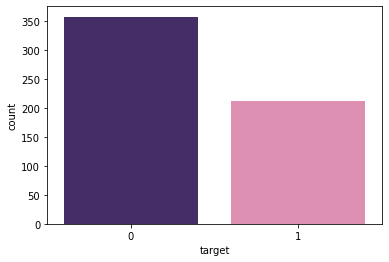

In [7]:
sns.countplot(data["target"], palette=['#432371',"#EA83AF"] )
print(data.target.value_counts())

In [8]:
print(len(data))

569


In [9]:
print("Data Shape", data.shape)

Data Shape (569, 31)


In [10]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [11]:
data.describe()

,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


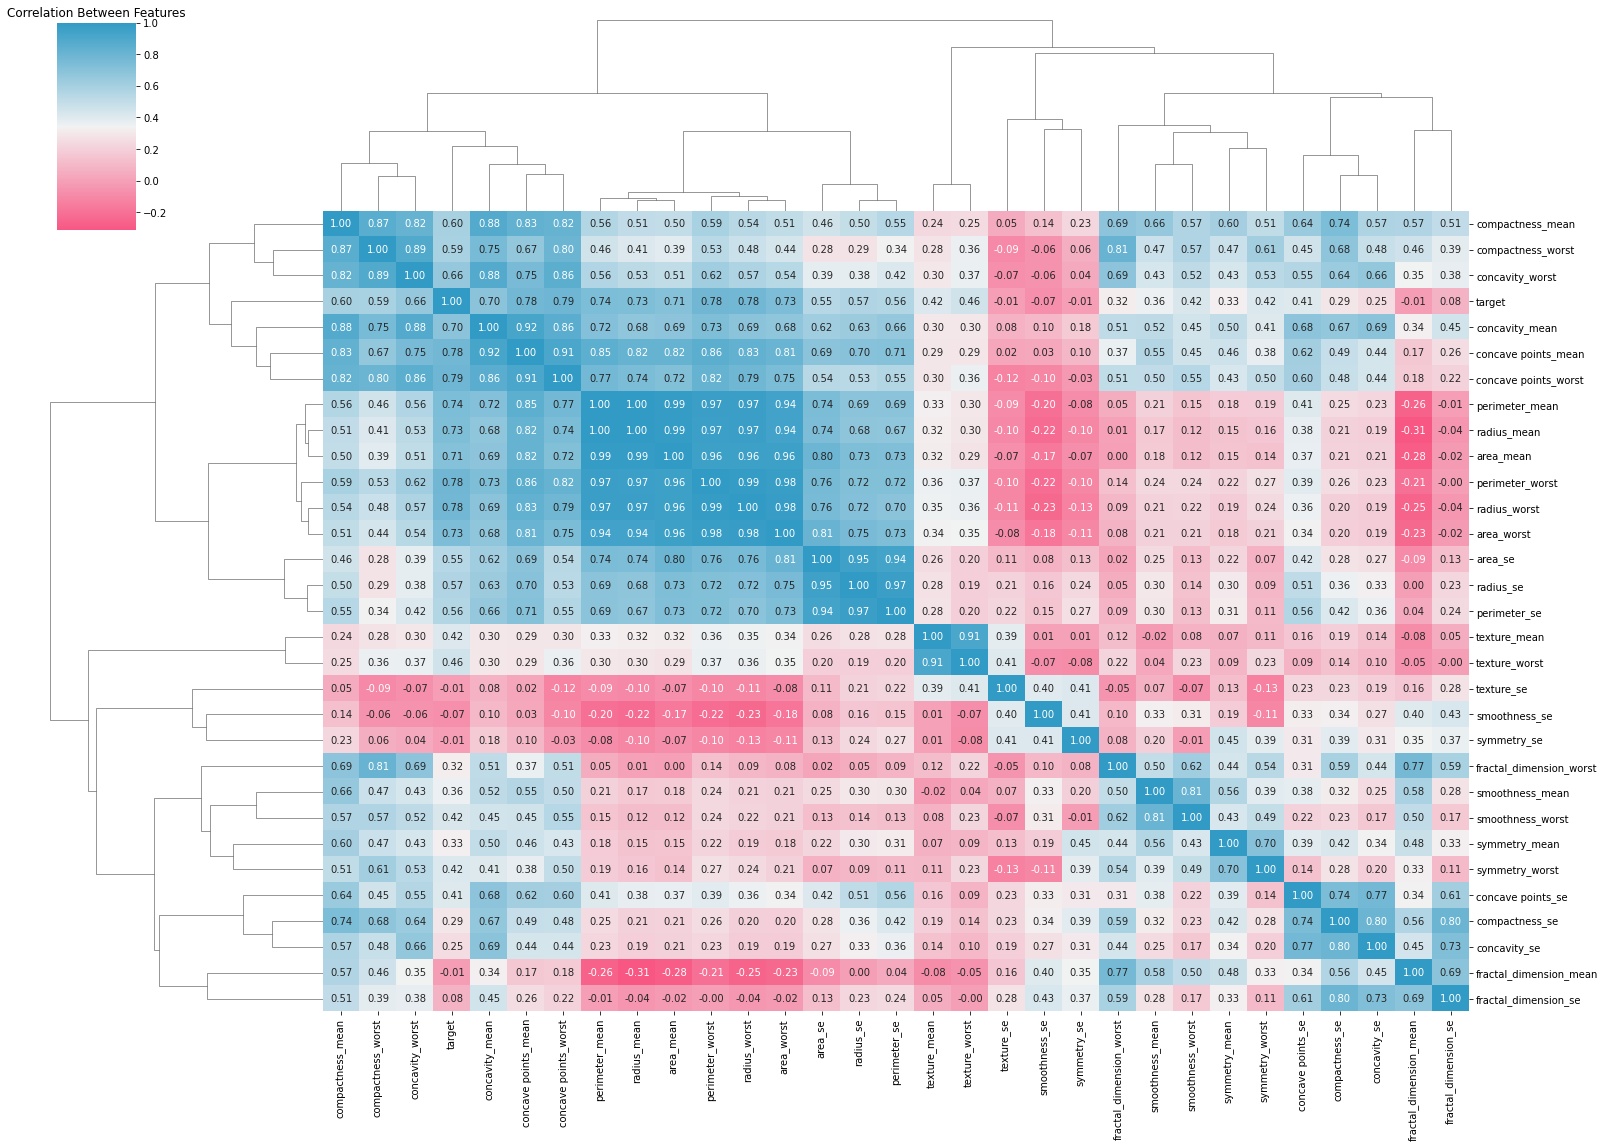

In [12]:
#Explore data analysis
#Correlation
corr_matrix = data.corr()
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.clustermap(corr_matrix, annot = True, fmt = ".2f",cmap=cmap ,figsize=(22,16))
plt.title("Correlation Between Features")
plt.show()

Text(0.5, 1.0, 'Correlation Between Features w corr threshold 0.75')

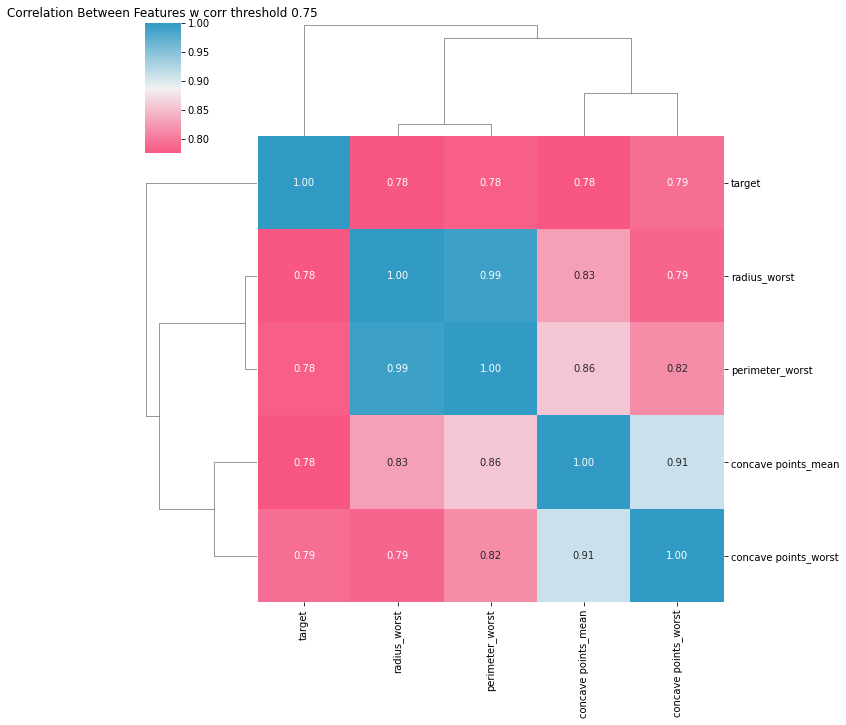

In [13]:
#there some correlated features
threshold = 0.75
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.clustermap(data[corr_features].corr(),cmap=cmap, annot = True, fmt = ".2f")
plt.title("Correlation Between Features w corr threshold 0.75")

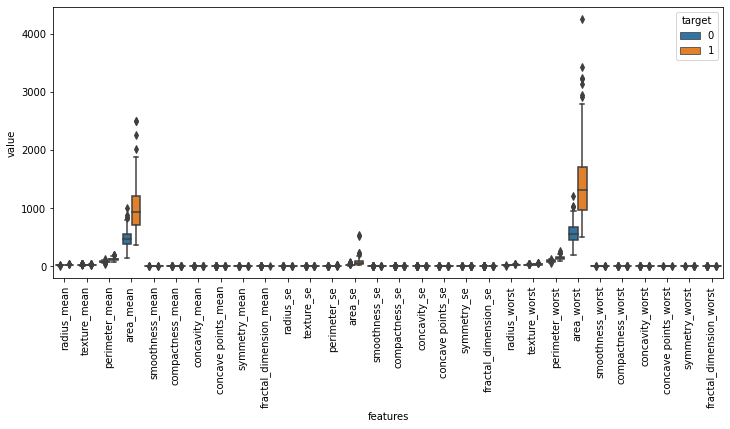

'\nstandartization-normalization\n'

In [14]:
#box plot
data_melted = pd.melt(data, id_vars = "target", 
                      var_name = "features",
                      value_name = "value")
plt.figure(figsize=(12,5))
sns.boxplot(x = "features", y= "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()
"""
standartization-normalization
"""

In [15]:
y = data["target"]
x = data.drop(["target"], axis = 1)
columns = x.columns.tolist()

In [16]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [17]:
#Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02
mean,-6.504969e-16,-2.453697e-16,-2.431545e-16,4.599868e-16,-7.781986e-16,-2.413302e-16,3.049204e-17,-1.245743e-16,-1.088201e-15,-8.029571e-16,-3.049204e-17,6.776009e-17,1.704427e-16,-4.300160e-17,-2.486274e-16,7.922718e-17,-1.329140e-17,-1.813886e-16,-1.571513e-16,1.667941e-17,5.055945e-17,1.146709e-16,-3.679894e-16,-3.857113e-17,5.569358e-16,5.733546e-18,-9.199735e-17,-9.121551e-17,-2.443273e-16,4.287129e-16
std,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00
min,-1.821698e+00,-2.245464e+00,-1.811055e+00,-1.360924e+00,-3.076187e+00,-1.616996e+00,-1.113998e+00,-1.262519e+00,-2.364007e+00,-1.751926e+00,-1.015416e+00,-1.558772e+00,-1.005723e+00,-6.948454e-01,-1.722294e+00,-1.268216e+00,-1.076902e+00,-1.887318e+00,-1.576653e+00,-1.076783e+00,-1.577443e+00,-2.240382e+00,-1.586048e+00,-1.151512e+00,-2.588000e+00,-1.477280e+00,-1.346979e+00,-1.750549e+00,-2.134753e+00,-1.611928e+00
25%,-6.812361e-01,-7.143877e-01,-6.748468e-01,-6.552099e-01,-7.426857e-01,-7.789958e-01,-7.450121e-01,-7.250555e-01,-6.943473e-01,-7.060443e-01,-5.811912e-01,-6.731382e-01,-5.689046e-01,-4.571792e-01,-6.348964e-01,-6.980019e-01,-5.705343e-01,-6.552898e-01,-6.587939e-01,-5.761417e-01,-6.594145e-01,-7.424337e-01,-6.787063e-01,-6.252800e-01,-7.329567e-01,-7.108939e-01,-7.712246e-01,-7.706801e-01,-6.507157e-01,-7.234183e-01
50%,-2.415077e-01,-1.204154e-01,-2.450999e-01,-3.069173e-01,-8.500554e-02,-2.334595e-01,-3.320246e-01,-3.881658e-01,-6.997499e-02,-1.817180e-01,-2.877772e-01,-1.833268e-01,-2.774535e-01,-3.177650e-01,-2.015228e-01,-2.708419e-01,-2.074376e-01,-1.193139e-01,-2.208398e-01,-2.284481e-01,-2.610680e-01,-6.758880e-02,-2.791430e-01,-3.315219e-01,-4.750043e-02,-2.779756e-01,-2.125778e-01,-2.262222e-01,-1.096984e-01,-1.979431e-01
75%,4.609248e-01,5.652558e-01,5.062622e-01,3.524510e-01,6.248089e-01,5.459893e-01,5.260445e-01,5.991668e-01,5.730632e-01,4.665902e-01,2.174645e-01,4.438819e-01,1.834738e-01,6.967637e-02,3.698379e-01,3.672240e-01,3.407934e-01,4.361738e-01,3.193347e-01,2.562722e-01,4.633886e-01,6.616590e-01,5.021245e-01,2.781347e-01,6.336447e-01,6.262271e-01,5.755155e-01,6.930046e-01,4.496102e-01,4.835659e-01
max,3.961758e+00,4.752051e+00,3.979870e+00,5.185291e+00,4.861839e+00,4.063429e+00,4.321607e+00,4.057905e+00,4.628217e+00,4.825355e+00,8.633442e+00,6.763792e+00,9.126084e+00,1.046659e+01,7.795101e+00,6.035219e+00,1.213268e+01,6.521053e+00,5.122762e+00,9.715775e+00,4.151627e+00,3.992278e+00,4.368354e+00,5.987244e+00,3.759153e+00,4.625193e+00,3.487498e+00,2.771385e+00,6.113423e+00,5.105498e+00


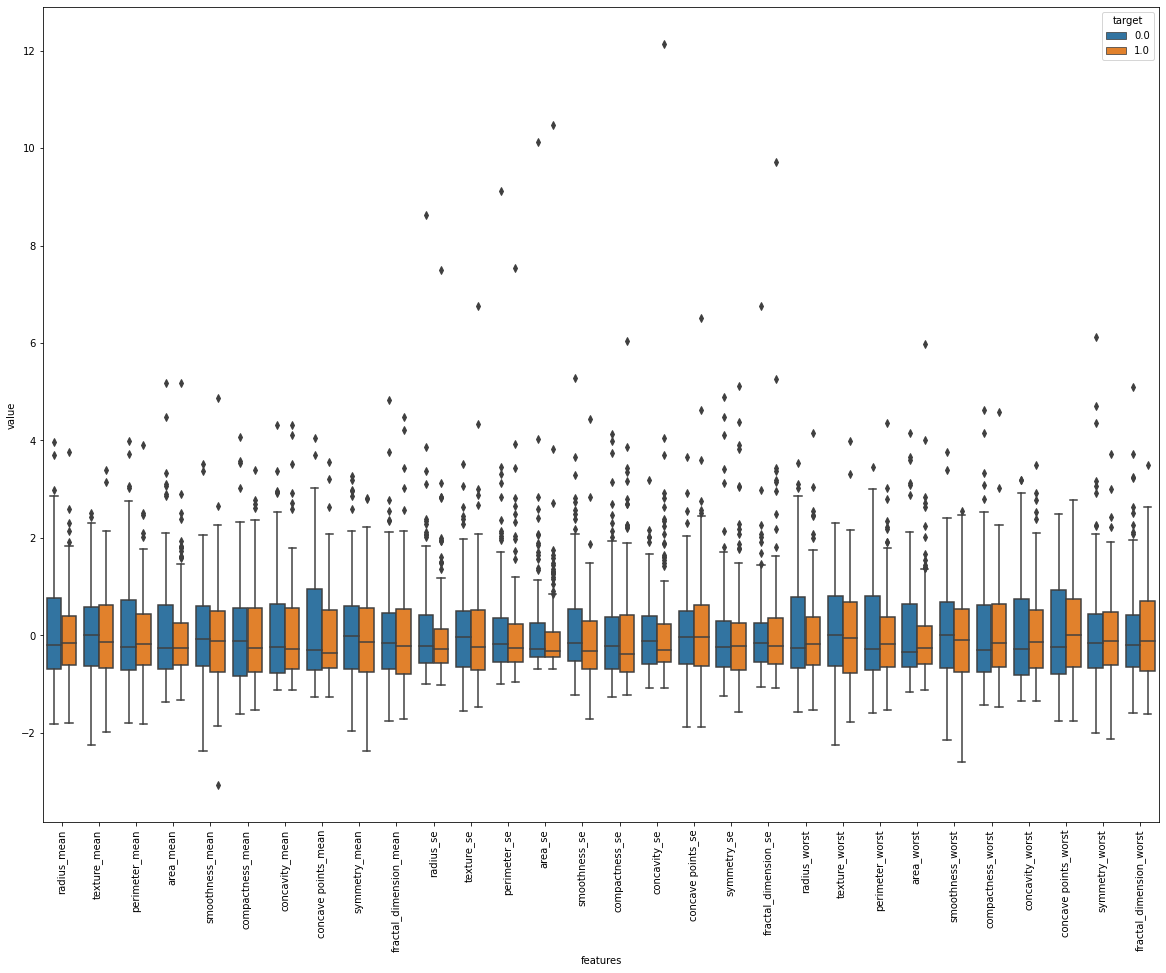

In [18]:
X_train_df_describe = X_train_df.describe()
X_train_df["target"] = Y_train 
#box plot
data_melted = pd.melt(X_train_df, id_vars = "target", 
                      var_name = "features",
                      value_name = "value")
plt.figure(figsize=(20,15))
sns.boxplot(x = "features", y= "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:

#### Basic K-Nearest Neighbour Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
y_pred_train_knn = knn.predict(X_train)
y_pred_test_knn = knn.predict(X_test)
acc_train_knn = accuracy_score(Y_train, y_pred_train_knn)
acc_test_knn = accuracy_score(Y_test, y_pred_test_knn)

print("KNN Train Accuracy: ", knn.score(X_train,Y_train))
print("KNN Test Accuracy: ", knn.score(X_test, Y_test))

print("Test Confusion Matrix:\n ", confusion_matrix(Y_test, y_pred_test_knn))
print(classification_report(y_pred_test_knn, Y_test))
print("ROC-AUC Score of RF: ", roc_auc_score(Y_test, y_pred_test_knn))


KNN Train Accuracy:  0.9788732394366197
KNN Test Accuracy:  0.958041958041958
Test Confusion Matrix:
  [[86  3]
 [ 3 51]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.94      0.94      0.94        54

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143

ROC-AUC Score of RF:  0.9553682896379525


Train-Accuracy of SVM Algorithm:  0.9835680751173709
Test-Accuracy of SVM Algorithm:  0.9790209790209791
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        90
           1       0.96      0.98      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

ROC-AUC Score of SVM:  0.9758635039533915


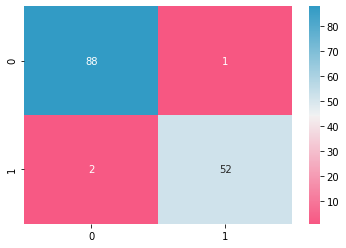

In [21]:
#SVM
from sklearn.svm import SVC

svm =  SVC(kernel = "linear", random_state=42,C=0.1)

#Fitting the model for the train data
svm.fit(X_train, Y_train)
y_pred_train_svm = svm.predict(X_train)
y_pred_test_svm = svm.predict(X_test)
cm = confusion_matrix(Y_test, y_pred_test_svm)
acc_train_svm = accuracy_score(Y_train, y_pred_train_svm)
acc_test_svm = accuracy_score(Y_test, y_pred_test_svm)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
print("Train-Accuracy of SVM Algorithm: ", svm.score(X_train,Y_train))
print("Test-Accuracy of SVM Algorithm: ", svm.score(X_test, Y_test))
sns.heatmap(cm,annot=True,fmt='g', cmap=cmap)
print(classification_report(y_pred_test_svm, Y_test))
print("ROC-AUC Score of SVM: ", roc_auc_score(Y_test, y_pred_test_svm))


In [22]:
#### Random Forest Classifier

#Initializing the model
rf = RandomForestClassifier(n_estimators=10, random_state=42)
#Fitting the model for the train data
rf.fit(X_train, Y_train)
#Predicting for the unseen/test data
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
#Calculating the accuracy of the model
acc_train_rf = accuracy_score(Y_train, y_pred_train_rf)
acc_test_rf = accuracy_score(Y_test, y_pred_test_rf)

print("Train-Accuracy of RF Algorithm: ", rf.score(X_train,Y_train))
print("Test-Accuracy of RF Algorithm: ", rf.score(X_test, Y_test))
print("Test Confusion Matrix:\n ", confusion_matrix(Y_test, y_pred_test_rf))
print(classification_report(y_pred_test_rf, Y_test))

print("ROC-AUC Score of RF: ", roc_auc_score(Y_test, y_pred_test_rf))


Train-Accuracy of RF Algorithm:  0.9953051643192489
Test-Accuracy of RF Algorithm:  0.951048951048951
Test Confusion Matrix:
  [[84  5]
 [ 2 52]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        86
           1       0.96      0.91      0.94        57

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143

ROC-AUC Score of RF:  0.953391593841032


Logistic Regression Training Accuracy: 0.9859154929577465
Logistic Regression Test Accuracy: 0.9790209790209791
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        88
           1       0.98      0.96      0.97        55

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

ROC-AUC Score of Logistic:  0.9795047856845608


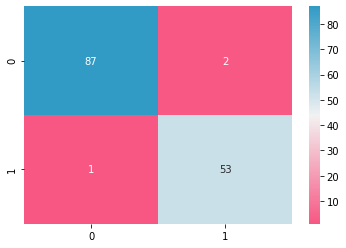

In [23]:
## Logistic Regression

from sklearn.linear_model import LogisticRegression
#Fitting the Logistic Regression Algorithm to the Training Set
log = LogisticRegression(random_state = 42)
log.fit(X_train, Y_train)
#predicting the Test set results
y_pred_train_log = log.predict(X_train)
y_pred_test_log = log.predict(X_test)
acc_train_log = accuracy_score(Y_train, y_pred_train_log)
acc_test_log = accuracy_score(Y_test, y_pred_test_log)
cm = confusion_matrix(Y_test, y_pred_test_log)
print('Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
print('Logistic Regression Test Accuracy:', log.score(X_test, Y_test))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(cm,annot=True,fmt='g', cmap=cmap)
print(classification_report(y_pred_test_log, Y_test))
print("ROC-AUC Score of Logistic: ", roc_auc_score(Y_test, y_pred_test_log))


In [24]:
modeller = []

K = [SVC(kernel = "linear", random_state=42) ,LogisticRegression(random_state=42) , KNeighborsClassifier() ,
    RandomForestClassifier(n_estimators=10, random_state=42)]


L= ["SVC" ,"LogisticRegression" , "KNeighborsClassifier" ,
    "RandomForestClassifier"]
for i in range(0,len(K)):
    model1 = K[i]
    model1.fit( X_train , Y_train )
    pred = model1.predict(X_train)
    modeller.append(accuracy_score(pred , Y_train))    

In [25]:
d = { "Accuracy" : modeller , "Algorithm" : L }
data_frame = pd.DataFrame(d)
data_frame

,Accuracy,Algorithm
0,0.992958,SVC
1,0.985915,LogisticRegression
2,0.978873,KNeighborsClassifier
3,0.995305,RandomForestClassifier


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Accuracy of all Algorithms')

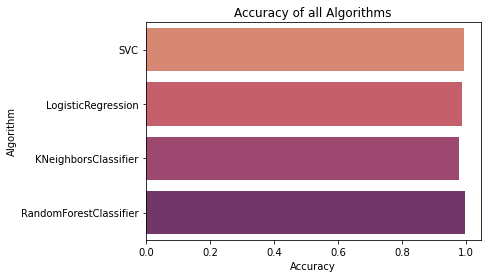

In [26]:
sns.barplot(data_frame['Accuracy'],data_frame['Algorithm'],palette= "flare").set_title('Accuracy of all Algorithms')

In [27]:
models = []

Z = [SVC(kernel = "linear", random_state=42) ,LogisticRegression(random_state=42) , KNeighborsClassifier() ,
    RandomForestClassifier(n_estimators=10, random_state=42)]


X = ["SVC" ,"LogisticRegression" , "KNeighborsClassifier" ,
    "RandomForestClassifier"]

for i in range(0,len(Z)):
    model = Z[i]
    model.fit( X_train , Y_train )
    pred = model.predict(X_test)
    models.append(accuracy_score(pred , Y_test))

In [28]:
d = { "Accuracy" : models , "Algorithm" : X }
data_frame = pd.DataFrame(d)
data_frame

,Accuracy,Algorithm
0,0.972028,SVC
1,0.979021,LogisticRegression
2,0.958042,KNeighborsClassifier
3,0.951049,RandomForestClassifier


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Accuracy of all Algorithms')

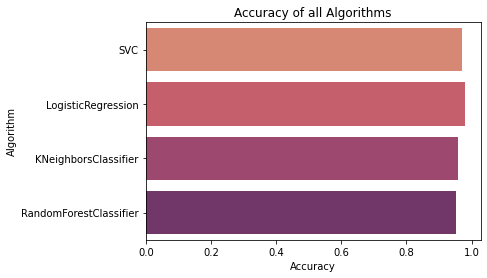

In [29]:
sns.barplot(data_frame['Accuracy'],data_frame['Algorithm'],palette= "flare").set_title('Accuracy of all Algorithms')

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001]}

grid = GridSearchCV( SVC(), param_grid, verbose=3)


grid.fit(X_train, Y_train)

grid.best_params_
grid.best_estimator_
grid_predictions = grid.predict(X_test)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.628, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.635, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.635, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.624, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.624, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.942, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ..........

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.8s finished


In [31]:
print(confusion_matrix(Y_test,grid_predictions))

print(classification_report(Y_test,grid_predictions))

grid.score(X_test, Y_test)

[[87  2]
 [ 2 52]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        89
           1       0.96      0.96      0.96        54

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



0.972027972027972

In [32]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('classifier' , LogisticRegression())])
param_grid = {'classifier' : [LogisticRegression()],
    'classifier__C':[0.1,1,10,100,1000],
    'classifier__solver' : ['liblinear']}
          


grid = GridSearchCV(pipe, param_grid = param_grid, cv = 6, verbose=True, n_jobs=-1)

# Fit on data

grid.fit(X_train, Y_train)
grid.best_params_
grid.best_estimator_

best_params_ = grid.best_params_
best_estimator_ = grid.best_estimator_
grid_predictions = best_estimator_.predict(X_test)

Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


tuned hpyerparameters :(best parameters)  {'classifier': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
accuracy : 0.9812206572769954


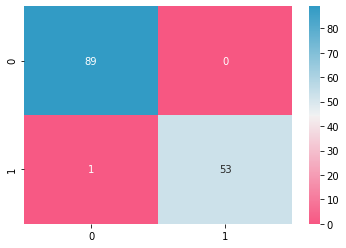

In [33]:
cm = confusion_matrix(Y_test,grid_predictions)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(cm,annot=True,fmt='g', cmap=cmap)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("accuracy :",grid.best_score_)